In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [2]:
def get_clean_values(offers):
    
    clean_values = pd.DataFrame(np.nan,index=range(0,offers.shape[0]),columns=["Currency", "Price", "Surface", "Floor", "Construction year", "Monthly charges"])
    
    # Extract Currency
    is_pln = offers["Price"].str.match(pat=".*zł",case=False,na=False)
    is_eur = offers["Price"].str.match(pat=".*eur",case=False,na=False)
    is_neither = ~(is_pln) & ~(is_eur)

    clean_values.loc[is_pln, "Currency"] = "PLN"
    clean_values.loc[is_eur, "Currency"] = "EUR"
    clean_values.loc[is_neither, "Currency"] = np.nan

    # Extract price, ignore decimal
    clean_values["Price"] = pd.to_numeric(offers["Price"].astype(str).str.replace(" ","").str.extract(pat="(\d+)",expand=False))

    # Extract surface, including decimal
    clean_values["Surface"] = pd.to_numeric(offers["Surface"].astype(str).str.replace(" ","").str.replace(",",".").str.extract(pat="(\d+\.?\d*)",expand=False))

    # Extract floor, floors >10 groupped together with 10
    clean_values["Floor"] = pd.to_numeric(offers["Floor"].astype(str).str.replace("parter","0",case=False).str.replace("suterena","-1",case=False).str.extract(pat="(-?\d+)",expand=False))

    clean_values["Construction year"] = pd.to_numeric(offers["Construction year"].astype(str).str.extract(pat="(\d+)",expand=False))
    clean_values[clean_values["Construction year"]<1900] =np.nan

    # Extract monthly charges, assume all values are in PLN, ignore decimal
    clean_values["Monthly charges"] = pd.to_numeric(offers["Monthly charges"].astype(str).str.replace(" ","").str.extract(pat="(\d+)",expand=False))

    return clean_values


In [3]:
# Load data - excel or SQL database
offers_excel = pd.read_excel("C:/Users/tomasz.starakiewicz/Documents/GitHub/DSBA-python-app/database/scraped_data_rental.xlsx")

In [4]:
# Clean numeric variables and add back to the dataset

offers_clean = get_clean_values(offers_excel)

offers = offers_excel.merge(right=offers_clean,left_index=True,right_index=True,suffixes=(None,"_clean"))
offers["Price per sqm"] = offers["Price_clean"] / offers["Surface_clean"]

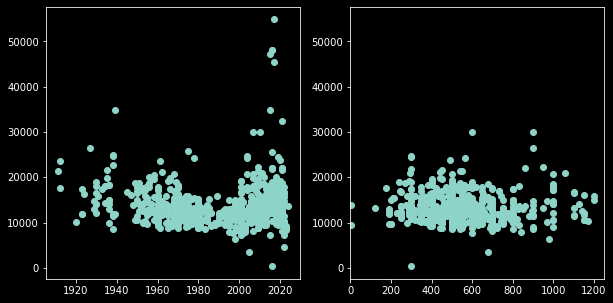

In [6]:
# Visualize data
# subplot https://towardsdatascience.com/clearing-the-confusion-once-and-for-all-fig-ax-plt-subplots-b122bb7783ca

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.scatter(offers["Construction year_clean"],offers["Price per sqm"])
ax2.scatter(offers["Monthly charges_clean"],offers["Price per sqm"])
ax2.set_xlim(0,1250)
charges_outliers = offers[offers["Monthly charges_clean"]>2000]


In [20]:
#cat_vars = ("Building type","Market type","Windows type","Heating type","Property condition")
num_vars = ["Monthly charges_clean","Floor_clean","Construction year_clean"]
predicted = ["Price per sqm"]
vars = num_vars + predicted

offers2 = offers.loc[:,vars].dropna()

Y = offers2.loc[:, predicted]
X = offers2.loc[:, num_vars] 

#X.loc[:,cat_vars].astype("category")

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

(517, 3)


In [21]:
# Need to encode labels:
# https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/
# Start with small model with numeric only
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

# example how to enable experimental mode with categorical vars for classifier
# model = XGBClassifier(tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False)
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [40]:
y_pred = model.predict(X_test)

score = model.score(X_train, y_train)
print("Model score: ", score)
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Mean cross validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Model score:  0.9952072183202693
Mean cross validation score: -0.47
K-fold CV average score: -0.14


MSE: 20553016.64
RMSE: 4533.54


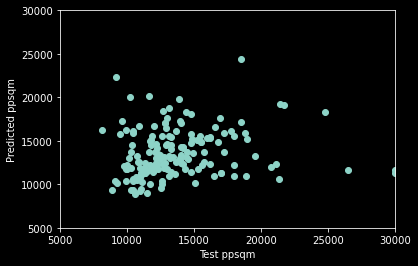

In [37]:
# https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

fig, ax = plt.subplots()

ax.scatter(y_test,y_pred)

ax.set_xlim(5000, 30000)
ax.set_ylim(5000, 30000)

ax.set_xlabel("Test ppsqm")
ax.set_ylabel("Predicted ppsqm")

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % mse**0.5)